# Feature Detection

In [1]:
# import methods from FIA python script
from FIA import *
import os

## Library Preparation

In [2]:
# set path to your mzML files and workfolder
data_dir = "../data/example data/exampleA_ecolistrains"
run_dir = "../runs/exampleA"

data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# clean_dir(run_dir)

In [3]:
# centroid_dir = centroid_batch(data_dir, run_dir, file_ending=".mzXML")

In [4]:
# merge_dir = merge_batch(centroid_dir, run_dir, file_ending=".mzML")

## Common steps

In [5]:
centroid_dir = "../runs/exampleA/centroids"
"""
feature_maps = untargeted_features_detection(centroid_dir, run_dir, ".mzML", 
                                            mass_error_ppm=10.0, noise_threshold_int=1000.0,
                                            charge_lower_bound=1, charge_upper_bound=3, 
                                            width_filtering="fixed", isotope_filtering_model="none", remove_single_traces="true",
                                            mz_scoring_by_elements="false", report_convex_hulls="true")
"""

'\nfeature_maps = untargeted_features_detection(centroid_dir, run_dir, ".mzML", \n                                            mass_error_ppm=10.0, noise_threshold_int=1000.0,\n                                            charge_lower_bound=1, charge_upper_bound=3, \n                                            width_filtering="fixed", isotope_filtering_model="none", remove_single_traces="true",\n                                            mz_scoring_by_elements="false", report_convex_hulls="true")\n'

In [6]:
feature_maps = read_feature_maps_XML("../runs/exampleA/features/")

In [ ]:
feature_maps_pol = assign_feature_maps_polarity(feature_maps)

In [ ]:
feature_maps_algn = align_retention_times(feature_maps_pol, 
                                    max_num_peaks_considered=-1,      # -1 -> consider infinite/all peaks
                                    max_mz_difference=10.0,
                                    mz_unit="ppm")

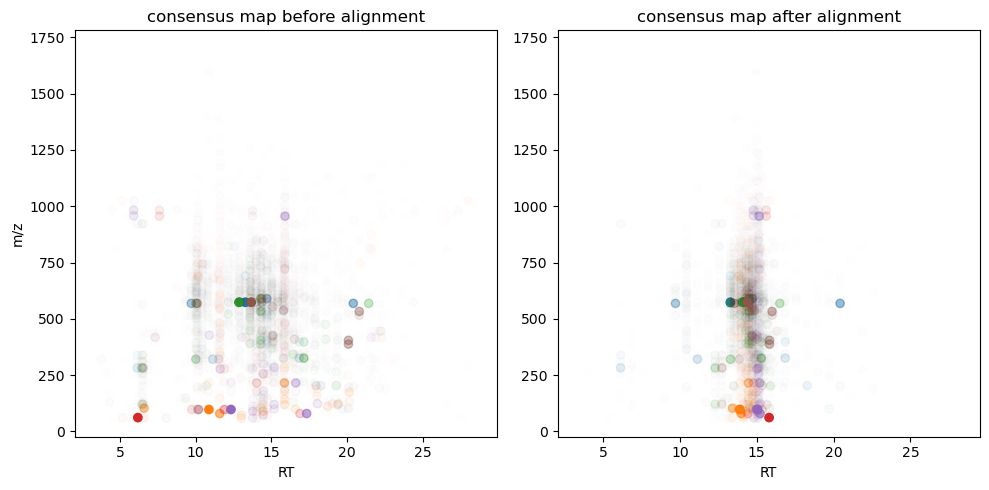

In [ ]:
plot_feature_map_rt_alignment(feature_maps_algn)

## Untargeted

In [ ]:
# pos_adducts = [b"H:+:0.4", b"Na:+:0.025", b"NH4:+:0.025", b"H-1O-1:+:0.025", b"H-3O-2:+:0.025"]
# neg_adducts = [b"H:-:0.4", b"Na:-:0.025", b"NH4:-:0.025", b"H-1O-1:-:0.025", b"H-3O-2:-:0.025"]
# feature_maps = detect_adducts(feature_maps, potential_adducts=pos_adducts + neg_adducts)

In [ ]:
# store_feature_maps(feature_maps, "untargeted_features")

## Targeted

#### From mass

In [ ]:
feature_map_pos, feature_map_neg = separate_feature_maps_pos_neg(feature_maps=feature_maps_algn)

In [ ]:
consensus_map_pos = consensus_features_linking(feature_map_pos, feature_grouper="KD")
consensus_map_pos = assign_feature_maps_polarity([consensus_map_pos], "positive")
consensus_map_neg = consensus_features_linking(feature_map_neg, feature_grouper="KD")
consensus_map_neg = assign_feature_maps_polarity([consensus_map_neg], "negative")

Progress of 'computing RT transformations':
-- done [took 0.22 s (CPU), 0.22 s (Wall)] -- 
Progress of 'linking features':
-- done [took 0.45 s (CPU), 0.45 s (Wall)] -- 


TypeError: 'NoneType' object is not subscriptable

In [ ]:
cm = consensus_map_pos[0]
cm.setMetaValue("scan_polarity", "positive")
cm.getMetaValue("scan_polarity")

'positive'

In [ ]:
cm_pos_df = consensus_map_to_df(consensus_map_pos)
filtered_cm_pos_df = filter_consensus_map_df(cm_pos_df, max_missing_values=1, min_feature_quality=sorted(cm_pos_df["quality"], reverse=True)[100])
imputed_cm_pos_df = impute_consensus_map_df(filtered_cm_pos_df, n_nearest_neighbours=2)

cm_neg_df = consensus_map_to_df(consensus_map_neg)
filtered_cm_neg_df = filter_consensus_map_df(cm_neg_df, max_missing_values=1, min_feature_quality=sorted(cm_neg_df["quality"], reverse=True)[100])
imputed_cm_neg_df = impute_consensus_map_df(filtered_cm_neg_df, n_nearest_neighbours=2)

In [ ]:
mass_search_df = accurate_mass_search(consensus_map_pos, "../databases/HMDB/", "../runs/exampleA/tmp",
 "PositiveAdducts.tsv", "NegativeAdducts.tsv", "HMDBMappingFile.tsv", "HMDB2StructMapping.tsv", ionization_mode="auto")

Read 9635 entries from mapping file!
Read 33 entries from adduct file '../databases/HMDB/PositiveAdducts.tsv'.
Read 15 entries from adduct file '../databases/HMDB/NegativeAdducts.tsv'.


RuntimeError: Auto ionization mode could not resolve ion mode of data (Meta value 'scan_polarity' not found in (Consensus-)Feature map!

In [ ]:
id_df = consensus_map_df_to_id_df(imputed_cm_df, mass_search_df, "../runs/tr1/results")
# id_df = anntotate_consensus_map_df(imputed_cm_df, mass_search_df, "../runs/tr1/results")

In [ ]:
plot_id_df(id_df)

#### From mass, charge & retention time

In [ ]:
mt = define_metabolite_table("../databases/compounds.tsv", [50.0, 3000.0])
len(mt)

In [ ]:
fm = feature_detection_targeted("../runs/tr_example/centroided_experiment.MzML", mt, mz_window=5.0, rt_window=200.0, peak_width=3.0)

In [ ]:
oms.FeatureXMLFile().store("../runs/tr_example/targeted.featureXML", fm)